# Finding Indicators of Heavy Traffic on the I-94

This project will examine the traffic on the I-94 Interstate highway in the US. The highway connects the Great Lakes and northern Great Plains regions. The data was collected at a station located approximately halfway between Saint Paul and Minneapolis and only recorded westbound traffic.

The dataset used was collected by John Hogue and made available at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).
The dataset contains information for the period 2012-2018 and the following columns:

- `holiday` Categorical US National holidays plus regional holiday
- `temp` Numerical average temperature in kelvin
- `rain_1h` Numerical amount in mm of rain that occurred in a hour
- `snow_1h` Numerical amount in mm of snow that occurred in a hour
- `clouds_all` Numerical percentage of cloud cover
- `weather_main` Categorical, short textual description of the current weather
- `weather_description` Categorical, longer textual description of the current weather
- `date_time` DateTime hour of the data collected in local CST time
- `traffic_volume` Numerical, hourly I-94 ATR 301 reported westbound traffic volume

The goal of the analysis is to look for indicators of heavy traffic on the Interstate. The indicators could be time-of-day, weather, week day, etc. Due to the data being collected solely at one station, we can only apply our findings with certainty to that area of the highway, and may not be able to generalize the findings to the Interstate as a whole. The station also recorded westbound traffic only.

# 1.0 Examining the data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime as dt
from IPython.display import display;

%matplotlib inline

traffic = pd.read_csv("metro_interstate_traffic_volume.csv")

In [2]:
display(traffic.head())
display(traffic.info())

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


None

## 1.1 Examining the `traffic_volume` column

C:\Users\Mats\AppData\Local\Temp\ipykernel_11960\1771153617.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


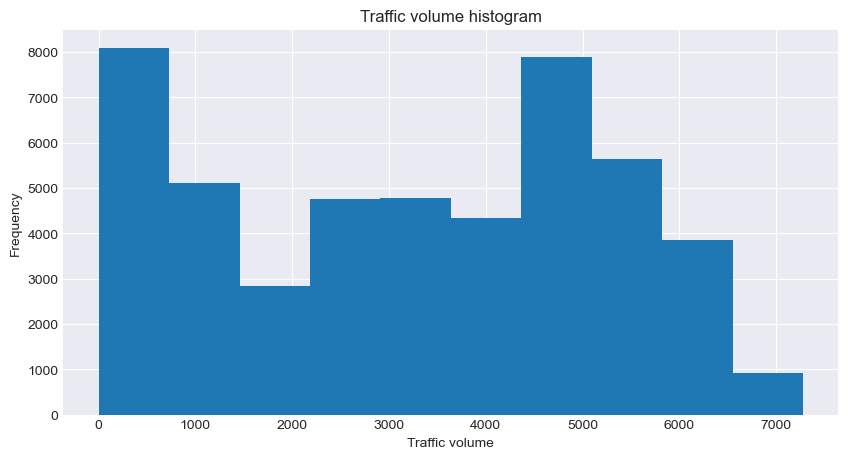

In [3]:
#plotting a histogram of `traffic_volume`
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(10,5))
traffic["traffic_volume"].plot(kind="hist")
plt.title('Traffic volume histogram')
plt.xlabel("Traffic volume")

plt.show()

In [4]:
traffic["traffic_volume"].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

From the information above we can see that the `traffic_volume` column contains no null values and that the mean value is approximately 3259.
There is a high frequency of low traffic volume (0-1000) and a notable spike in frequency around traffic volume of 5000. These two spikes likely correspond to nighttime and daytime, respectively.

## 1.2 Exploring the correlation between `traffic_volume` and `date_time` columns

First, we will convert the `date_time` column to the datetime format.
Next, we will divide the data set into two parts:
- Daytime data: the hours from 07:00 to 18:00 (inclusive).
- Nighttime data: the hours from 19:00 to 06:00 (inclusive).

In [5]:
#converting the `date_time` column to datetime type
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
traffic['date_time']

0       2012-10-02 09:00:00
1       2012-10-02 10:00:00
2       2012-10-02 11:00:00
3       2012-10-02 12:00:00
4       2012-10-02 13:00:00
                ...        
48199   2018-09-30 19:00:00
48200   2018-09-30 20:00:00
48201   2018-09-30 21:00:00
48202   2018-09-30 22:00:00
48203   2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: datetime64[ns]

In [6]:
#dividing the data set into daytime and nighttime
traffic_day = traffic[traffic['date_time'].dt.hour.between(7,18)].copy()
traffic_night = traffic[(traffic['date_time'].dt.hour >= 19) | (traffic['date_time'].dt.hour <= 6)].copy()

print(traffic_day['date_time'].dt.hour.value_counts().sort_index(), '\n')
print(traffic_night['date_time'].dt.hour.value_counts().sort_index())

7     2079
8     2080
9     2018
10    2078
11    1952
12    1955
13    1905
14    1969
15    1934
16    1988
17    1933
18    1986
Name: date_time, dtype: int64 

0     2037
1     2049
2     2019
3     2025
4     2091
5     2063
6     2087
19    1961
20    1979
21    1982
22    1994
23    2040
Name: date_time, dtype: int64


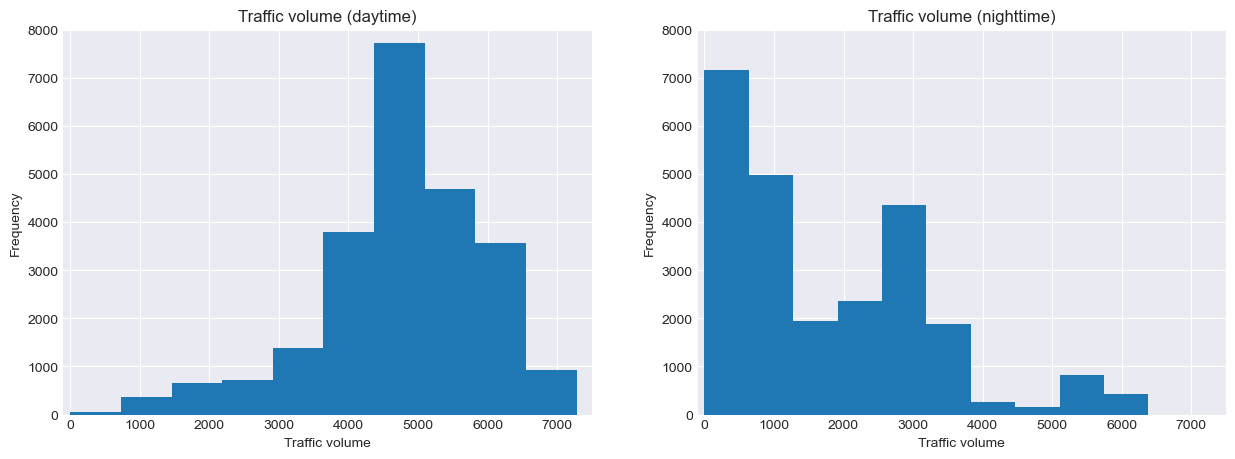

In [7]:
#plotting `traffic_volume` for daytime and nighttime
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
traffic_day["traffic_volume"].plot(kind="hist")
plt.title('Traffic volume (daytime)')
plt.xlabel('Traffic volume')
plt.ylabel('Frequency')
plt.xlim(-100,7500)
plt.ylim(0,8000)

plt.subplot(1,2,2);
traffic_night["traffic_volume"].plot(kind="hist")
plt.title('Traffic volume (nighttime)')
plt.xlabel('Traffic volume')
plt.ylabel('Frequency')
plt.subplots_adjust(wspace=0.2)
plt.xlim(-100,7500)
plt.ylim(0,8000)

plt.show()

In [8]:
print(traffic_day['traffic_volume'].describe(), '\n')
print(traffic_night['traffic_volume'].describe())

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64 

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64


From the histograms we can see that the day traffic is left skewed and has a significantly higher volume than the night traffic. The traffic has a strong peak at a volume of about 4500-5000. The night traffic is right skewed and has a peak between approximately 0-1200, as well as a smaller peak at around 3000.

These observations from the histograms match well with the statistics for the `traffic_volume` column for both day and night traffic.
The goal is to find indicators of heavy traffic. For this reason the daytime data is most helpful and we will focus on that first. The nighttime data will be handled in a separate section.

## 1.3 Exploring daytime traffic data

### 1.3.1 Exploring the effect of date and time on traffic volume

We will check if the date and time has any predictable effect on the traffic. We will examine months, days, and hours to look for patterns.

In [9]:
#grouping daytime data by month 
traffic_day.loc[:, 'month'] = traffic_day.loc[:,'date_time'].dt.month
group_month_day = traffic_day.groupby('month').mean()
group_month_day['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

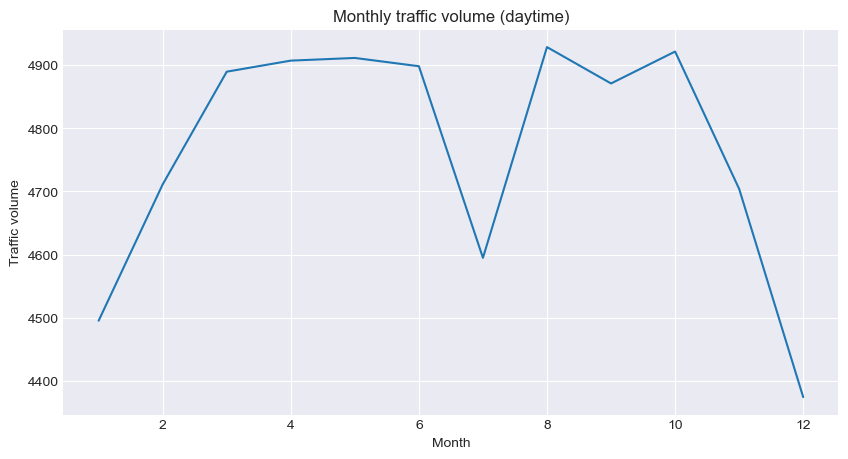

In [10]:
#creating line plot
plt.figure(figsize=(10,5))
group_month_day['traffic_volume'].plot()
plt.title('Monthly traffic volume (daytime)')
plt.xlabel('Month')
plt.ylabel('Traffic volume')

plt.show()

There is a notable dip in traffic volume during July. This likely corresponds to the summer holidays; indicating that people are on vacation.
Another dip in traffic happens in December-January. This might be related to the Christmas holidays or the fact that the weather tends to be worse during the winter months.

In [11]:
#grouping daytime data by day of week
traffic_day.loc[:, 'weekday'] = traffic_day.loc[:, 'date_time'].dt.dayofweek
group_day_daytime = traffic_day.groupby('weekday').mean()
group_day_daytime['traffic_volume'] #0 is Monday and 6 is Sunday

weekday
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

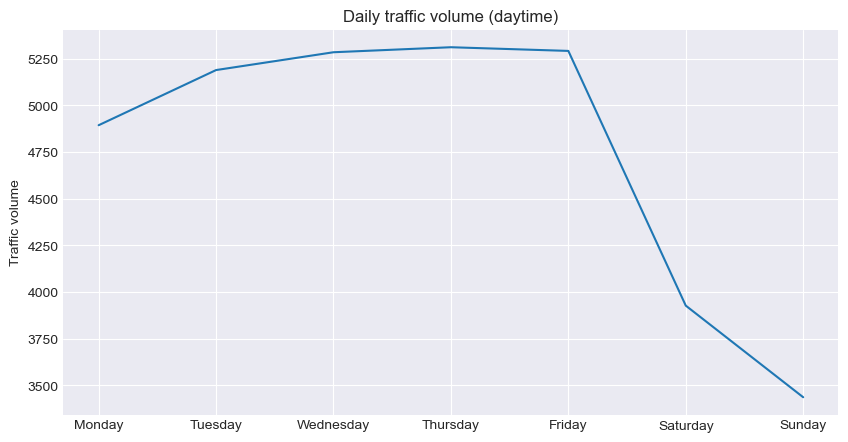

In [12]:
#creating line plot
plt.figure(figsize=(10,5))
group_day_daytime['traffic_volume'].plot()
plt.title('Daily traffic volume (daytime)')
plt.xlabel('')
plt.ylabel('Traffic volume')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

As expected, the traffic is consistent across all the weekdays and then drops of dramatically during the weekend.

In [13]:
#grouping by time of day
traffic_day.loc[:, 'hour'] = traffic_day.loc[:, 'date_time'].dt.hour
workday_day_daytime = traffic_day[traffic_day['weekday'].between(0,4)].copy()
weekend_day_daytime = traffic_day[traffic_day['weekday'] >= 5].copy()

group_hour_workday_day = workday_day_daytime.groupby('hour').mean()
group_hour_weekend_day = weekend_day_daytime.groupby('hour').mean()

print("Hourly traffic (workdays):")
print(group_hour_workday_day['traffic_volume'], '\n')
print("Hourly traffic (weekend):")
print(group_hour_weekend_day['traffic_volume'], '\n')

Hourly traffic (workdays):
hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64 

Hourly traffic (weekend):
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64 



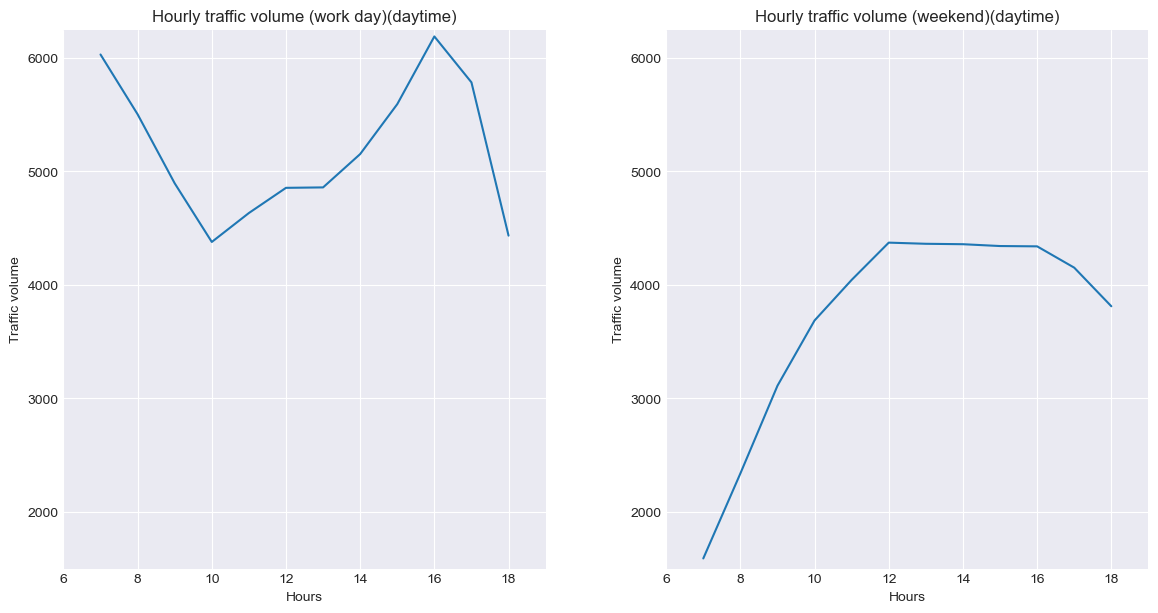

In [14]:
#creating line plot
plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
group_hour_workday_day['traffic_volume'].plot()
plt.title('Hourly traffic volume (work day)(daytime)')
plt.xlabel('Hours')
plt.ylabel('Traffic volume')
plt.xlim(6,19)
plt.ylim(1500, 6250)

plt.subplot(1,2,2)
group_hour_weekend_day['traffic_volume'].plot()
plt.title('Hourly traffic volume (weekend)(daytime)')
plt.xlabel('Hours')
plt.ylabel('Traffic volume')
plt.xlim(6,19)
plt.ylim(1500, 6250)

plt.show()

From the 'Workday' plot on the left it can clearly be seen that the rush hour traffic is around 07:00 and 16:00, as expected given typical work hours.  
On the weekends the busiest hours are between 11:00 and 16:00. The weekend traffic is much lower than the work day traffic even during peak hours.

### 1.3.2 Exploring the effect of weather on traffic volume

Next, we will explore the effect of weather indicators on the traffic volume for daytime traffic. Bad weather would likely mean that traffic moves slower, but also that fewer people would take to the roads.

The columns of interest are:

- `temp` Numerical average temperature in kelvin
- `rain_1h` Numerical amount, in mm, of rain that occurred in an hour
- `snow_1h` Numerical amount, in mm, of snow that occurred in an the hour
- `clouds_all` Numerical percentage of cloud cover
- `weather_main` Categorical, short textual description of the current weather
- `weather_description` Categorical, longer textual description of the current weather

All but the last two of these columns are numerical so we will start by looking up their correlation values with the `traffic_volume` column.

In [15]:
traffic_day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
weekday          -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

The weather indicator that has the strongest correlation with traffic volume is temperature. We will plot a scatter plot to visualize the correlation.

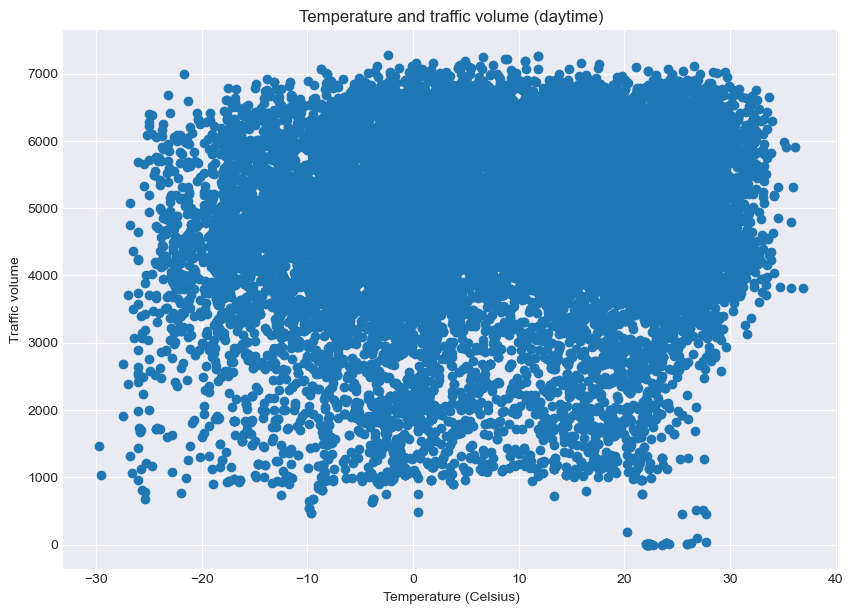

In [16]:
#removing a few outlier '0' values from the `temp` column
traffic_day = traffic_day[traffic_day['temp'] > 0]

#converting from Kelvin to Celsius using the formula: T(°C) = T(K) - 273.15
traffic_day['temp'] = traffic_day['temp'] - 273.15

#scatter plot
plt.figure(figsize=(10,7))
plt.scatter(x=traffic_day['temp'], y=traffic_day['traffic_volume'])
plt.title('Temperature and traffic volume (daytime)')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Traffic volume')

plt.show()

As expected from the correlation calculations there seems to be only a weak connection between temperature and traffic volume.

Since the numerical weather columns are not reliable indicators of heavy traffic, we will instead look at the two categorical weather columns: `weather_main` and `weather_description`.

In [17]:
#grouping by the categorical columns
group_weather_main_day = traffic_day.groupby('weather_main').mean()
group_weather_desc_day = traffic_day.groupby('weather_description').mean()

display(group_weather_main_day)
display(group_weather_desc_day)

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,weekday,hour
weather_main,,,,,,,,
Clear,10.760932,0.000000,0.000000,1.670846,4779.622257,6.492163,3.137931,12.405956
Clouds,9.779274,0.000000,0.000000,62.667548,4865.415996,6.393243,3.005631,12.911974
Drizzle,11.306433,0.170804,0.000000,84.704417,4837.212911,7.105323,2.934315,12.308041
Fog,4.429641,0.163840,0.001409,65.477901,4372.491713,6.646409,2.798343,10.325967
Haze,2.169353,0.040036,0.000000,64.000000,4609.893285,5.832134,2.754197,12.467626
Mist,6.270825,0.249992,0.000825,74.961435,4623.976475,6.734285,2.895102,11.078288
Rain,13.939601,3.972943,0.000292,75.870116,4815.568462,6.774023,2.914467,12.642379
Smoke,19.255833,0.878333,0.000000,53.333333,4564.583333,6.833333,2.416667,13.166667
Snow,-5.165495,0.014017,0.001768,80.501376,4396.321183,6.374828,2.750344,12.153370


,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,weekday,hour
weather_description,,,,,,,,
SQUALLS,23.580000,1.020000,0.000000,75.000000,4211.000000,7.000000,2.000000,14.000000
Sky is Clear,20.082549,0.000000,0.000000,0.000000,4919.009390,7.557512,2.895540,12.453052
broken clouds,9.222927,0.000000,0.000000,72.635875,4824.130326,6.675260,2.998210,12.811314
drizzle,10.423777,0.145072,0.000000,88.589928,4737.330935,7.244604,3.028777,11.697842
few clouds,11.122965,0.000000,0.000000,19.391951,4839.818023,6.159230,2.977253,12.633421
fog,4.429641,0.163840,0.001409,65.477901,4372.491713,6.646409,2.798343,10.325967
freezing rain,-0.290000,0.000000,0.000000,90.000000,4314.000000,6.500000,0.500000,13.500000
haze,2.169353,0.040036,0.000000,64.000000,4609.893285,5.832134,2.754197,12.467626
heavy intensity drizzle,12.317931,0.276207,0.000000,89.172414,4738.586207,7.551724,2.896552,12.275862


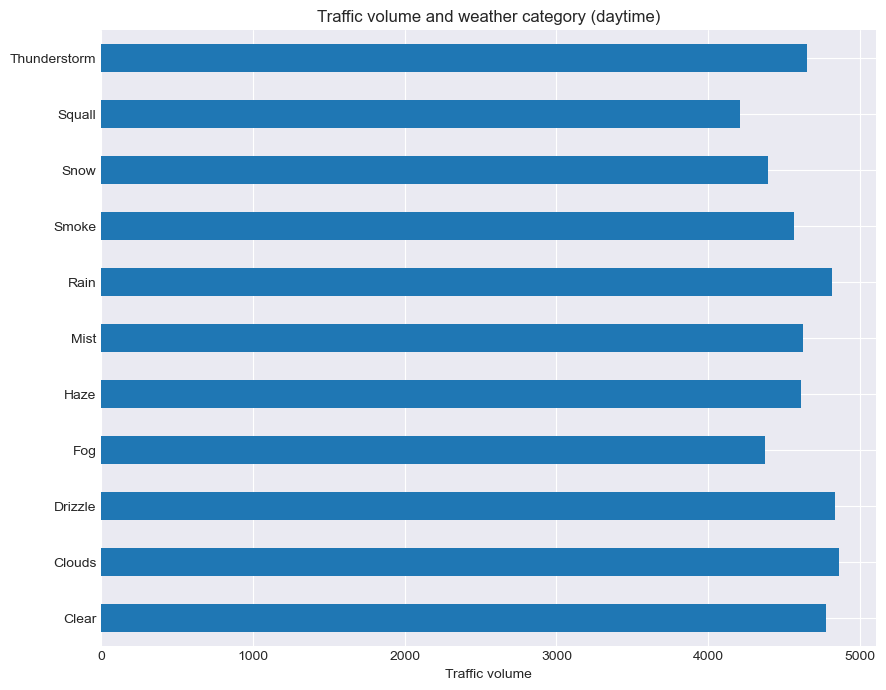

In [18]:
#creating bar plot for `weather_main`
plt.figure(figsize=(10,8))
group_weather_main_day['traffic_volume'].plot(kind='barh')
plt.title('Traffic volume and weather category (daytime)')
plt.xlabel('Traffic volume')
plt.ylabel('')

plt.show()

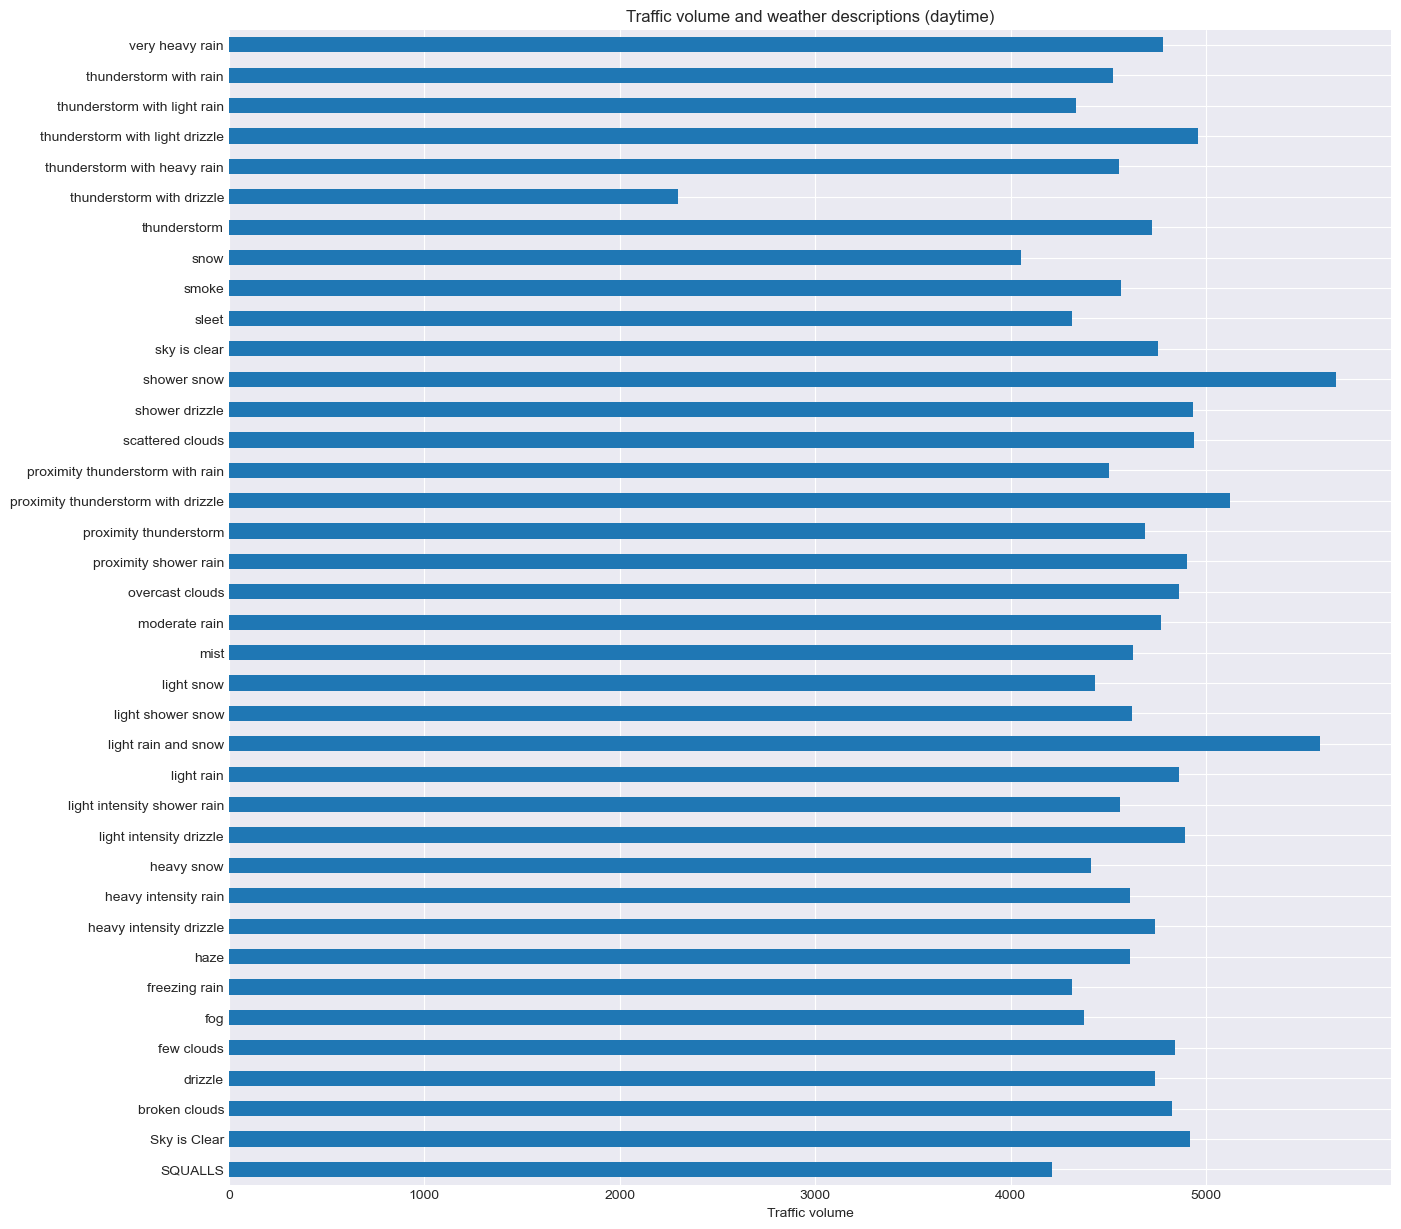

In [19]:
#creating bar plot for `weather_description`
plt.figure(figsize=(15,15))
group_weather_desc_day['traffic_volume'].plot(kind='barh')
plt.title('Traffic volume and weather descriptions (daytime)')
plt.xlabel('Traffic volume')
plt.ylabel('')

plt.show()

The bar plot for `weather_main` shows no strong indicators of a connection between traffic volume and weather. A small reduction in traffic can be seen with 'fog' and 'squall'.

The `weather_description` figure shows an increase in traffic for 'shower snow' and 'light rain and snow'. There is also a very notable drop in traffic for 'thunderstorm with drizzle'.

## 1.4 Exploring nighttime traffic data

Next, let us explore heavy traffic indicators for the nighttime traffic.

### 1.4.1 Exploring the effect of date and time on traffic volume

We will check if the date and time has any predictable effect on the traffic. We will examine months, days, and hours to look for patterns.

In [20]:
#grouping nightime data by month 
traffic_night.loc[:, 'month'] = traffic_night.loc[:,'date_time'].dt.month
group_month_night = traffic_night.groupby('month').mean()
group_month_night['traffic_volume']

month
1     1616.610448
2     1716.961841
3     1817.272029
4     1786.116598
5     1829.852518
6     1932.272727
7     1838.349193
8     1897.564079
9     1818.959858
10    1852.168591
11    1680.311799
12    1622.508393
Name: traffic_volume, dtype: float64

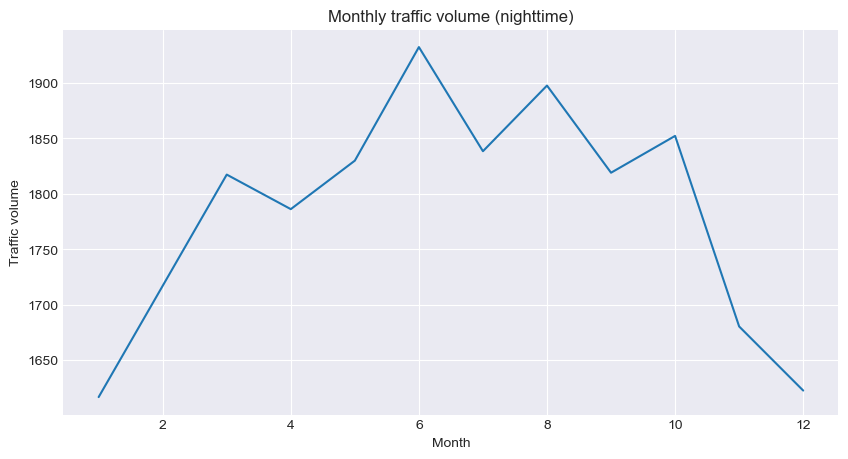

In [21]:
#creating line plot
plt.figure(figsize=(10,5))
group_month_night['traffic_volume'].plot()
plt.title('Monthly traffic volume (nighttime)')
plt.xlabel('Month')
plt.ylabel('Traffic volume')

plt.show()

There is a notable drop in traffic between October-February as in the daytime data plotted earlier. However, there is a small spike in the summer months rather than a large drop.

In [22]:
#grouping nighttime data by day of week
traffic_night.loc[:, 'weekday'] = traffic_night.loc[:, 'date_time'].dt.dayofweek
group_day_nighttime = traffic_night.groupby('weekday').mean()
group_day_nighttime['traffic_volume'] #0 is Monday and 6 is Sunday

weekday
0    1722.532692
1    1862.926571
2    1901.465710
3    1994.177959
4    2059.882336
5    1634.459412
6    1323.998273
Name: traffic_volume, dtype: float64

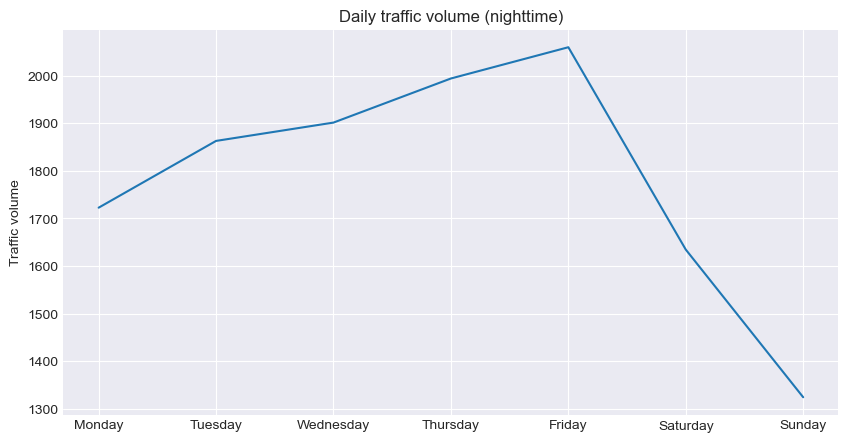

In [23]:
#creating line plot
plt.figure(figsize=(10,5))
group_day_nighttime['traffic_volume'].plot()
plt.title('Daily traffic volume (nighttime)')
plt.xlabel('')
plt.ylabel('Traffic volume')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

This is the same pattern as seen with the daytime data; traffic is fairly consistent across the weekdays and then drops of dramatically during the weekend.

In [25]:
#grouping by time of day
traffic_night['hour'] = traffic_night['date_time'].dt.hour

# Two df's. One for hours 0-7 and one for 19-23
traffic_night_1 = traffic_night.copy()[traffic_night['date_time'].dt.hour <=6]
traffic_night_2 = traffic_night.copy()[traffic_night['date_time'].dt.hour >=19]

workday_day_nighttime_1 = traffic_night_1.copy()[traffic_night_1['weekday'].between(0,4)]
weekend_day_nighttime_1 = traffic_night_1[traffic_night_1['weekday'] >= 5].copy()
group_hour_workday_night_1 = workday_day_nighttime_1.groupby('hour').mean()
group_hour_weekend_night_1 = weekend_day_nighttime_1.groupby('hour').mean()

#For the hours 19-23
workday_day_nighttime_2 = traffic_night_2.copy()[traffic_night_2['weekday'].between(0,4)]
weekend_day_nighttime_2 = traffic_night_2[traffic_night_2['weekday'] >= 5].copy()
group_hour_workday_night_2 = workday_day_nighttime_2.groupby('hour').mean()
group_hour_weekend_night_2 = weekend_day_nighttime_2.groupby('hour').mean()


print("Hourly traffic (workdays):")
print(group_hour_workday_night_1['traffic_volume'], '\n')
print("Hourly traffic (weekend):")
print(group_hour_weekend_night_1['traffic_volume'], '\n')

print("Hourly traffic (workdays):")
print(group_hour_workday_night_2['traffic_volume'], '\n')
print("Hourly traffic (weekend):")
print(group_hour_weekend_night_2['traffic_volume'])

Hourly traffic (workdays):
hour
0     651.528971
1     396.913043
2     301.982818
3     362.289835
4     832.661096
5    2701.296703
6    5365.983210
Name: traffic_volume, dtype: float64 

Hourly traffic (weekend):
hour
0    1306.414035
1     805.128333
2     611.171986
3     393.611599
4     375.420168
5     639.237232
6    1089.100334
Name: traffic_volume, dtype: float64 

Hourly traffic (workdays):
hour
19    3298.340426
20    2842.433004
21    2673.042807
22    2125.913104
23    1379.549728
Name: traffic_volume, dtype: float64 

Hourly traffic (weekend):
hour
19    3220.234120
20    2815.039216
21    2658.445242
22    2384.368607
23    1699.050699
Name: traffic_volume, dtype: float64


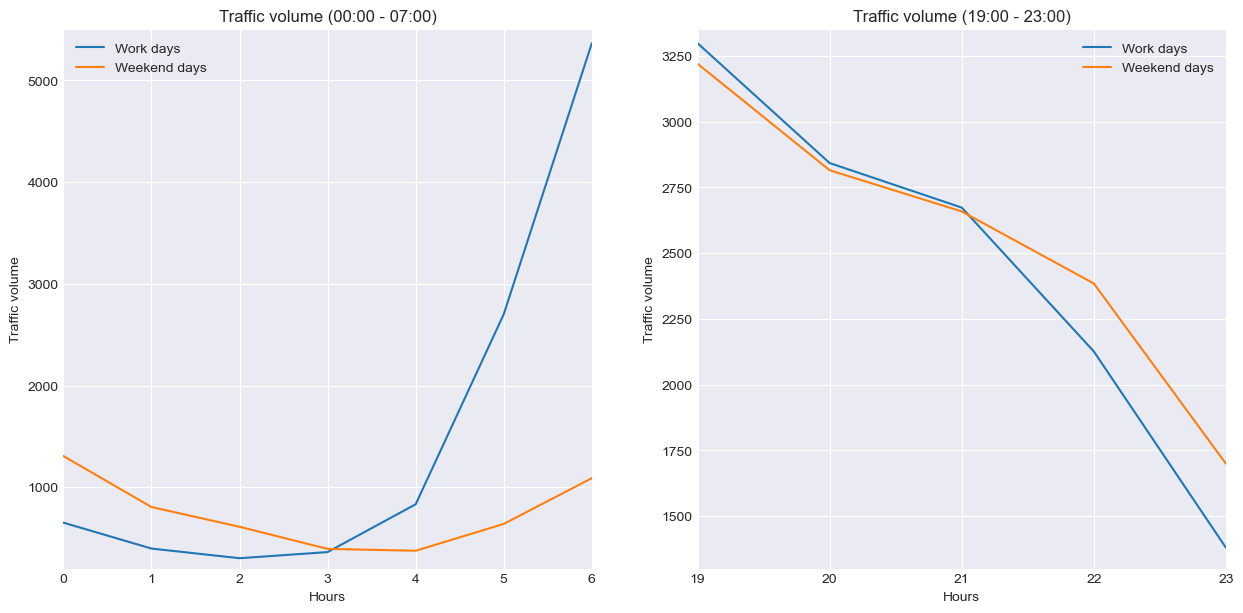

In [26]:
#creating line plot
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.20)

plt.subplot(1,2,1)
group_hour_workday_night_1['traffic_volume'].plot(label='Work days')
group_hour_weekend_night_1['traffic_volume'].plot(label='Weekend days')
plt.title('Traffic volume (00:00 - 07:00)')
plt.xlabel('Hours')
plt.ylabel('Traffic volume')
plt.legend()
plt.xlim(0, 6)
plt.ylim(200, 5500)


plt.subplot(1,2,2)
group_hour_workday_night_2['traffic_volume'].plot(label='Work days')
group_hour_weekend_night_2['traffic_volume'].plot(label='Weekend days')
plt.title('Traffic volume (19:00 - 23:00)')
plt.xlabel('Hours')
plt.ylabel('Traffic volume')
plt.xticks([19,20,21,22,23])
plt.legend()
plt.xlim(19, 23)
plt.ylim(1300, 3350)

plt.show()

For the hours 00:00 - 07:00 a clear difference can be seen around 05:00. There is a big spike corresponding to morning rush traffic for the work days, but only small increase for the days of the weekend. Traffic during the hours 19:00 - 23:00 is pretty similar for both work days and the weekend.

### 1.4.2 Exploring the effect of weather on traffic volume

In [27]:
traffic_night.corr()['traffic_volume']

temp              0.094004
rain_1h          -0.012972
snow_1h          -0.007453
clouds_all        0.012832
traffic_volume    1.000000
month             0.001342
weekday          -0.073636
hour              0.454586
Name: traffic_volume, dtype: float64

Temperature has the strongest correlation, followed by the day and time of day. We will make a scatterplot of the temperature correlation.

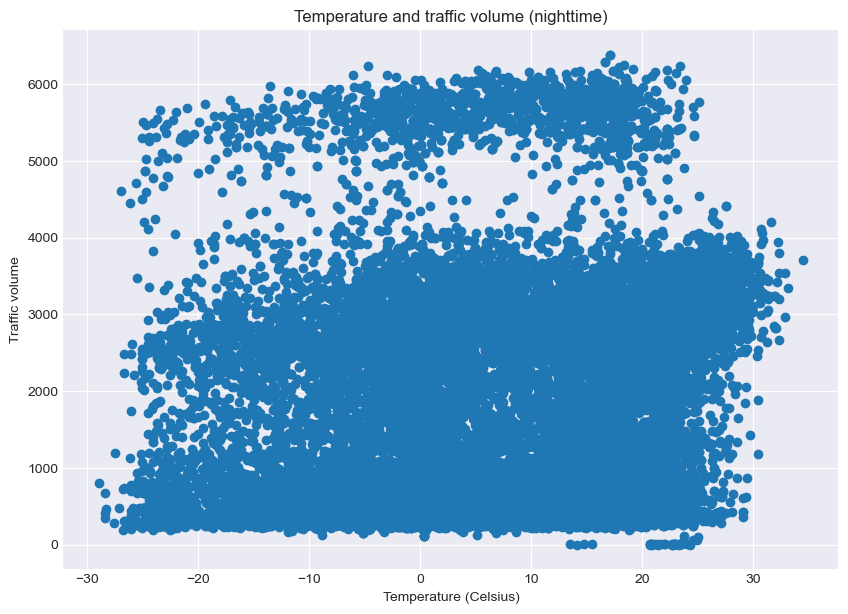

In [28]:
#removing a few outlier '0' values from the `temp` column
traffic_night = traffic_night[traffic_night['temp'] > 0]

#converting from Kelvin to Celsius using the formula: T(°C) = T(K) - 273.15
traffic_night['temp'] = traffic_night['temp'] - 273.15

#scatter plot
plt.figure(figsize=(10,7))
plt.scatter(x=traffic_night['temp'], y=traffic_night['traffic_volume'])
plt.title('Temperature and traffic volume (nighttime)')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Traffic volume')

plt.show()

The scatterplot for nighttime traffic and temperature looks similar to the one for daytime traffic; there is no clear pattern. As with the daytime data we will examine `weather_main` and `weather_description`.

In [29]:
#grouping by the categorical columns
group_weather_main_night = traffic_night.groupby('weather_main').mean()
group_weather_desc_night = traffic_night.groupby('weather_description').mean()

display(group_weather_main_night)
display(group_weather_desc_night)

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,weekday,hour
weather_main,,,,,,,,
Clear,6.888700,0.000000,0.000000,1.455426,1762.521534,6.493389,3.102762,10.350831
Clouds,6.345731,0.000000,0.000000,65.926029,1939.232745,6.274838,2.972764,11.869545
Drizzle,10.023188,0.145000,0.000000,80.074627,1834.920043,6.597015,2.797441,10.636461
Fog,7.474182,0.036436,0.000109,42.296364,1605.365455,6.727273,3.063636,6.456364
Haze,3.460133,0.057700,0.000000,50.220532,1745.640684,5.648289,2.914449,9.946768
Mist,6.370200,0.229333,0.000652,59.000596,1626.786119,6.761692,2.912720,8.273756
Rain,13.719183,0.583193,0.000081,69.317909,1814.952314,6.815966,2.906747,10.623101
Smoke,15.560000,0.000000,0.000000,53.375000,1247.250000,5.500000,3.750000,7.500000
Snow,-5.224789,0.036681,0.001540,82.450774,1606.324191,6.182138,2.832630,10.015471


,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,weekday,hour
weather_description,,,,,,,,
SQUALLS,17.790000,4.303333,0.000000,76.333333,1345.333333,6.333333,4.333333,8.666667
Sky is Clear,15.322426,0.000000,0.000000,0.000000,1964.941648,7.596110,2.885584,10.990847
broken clouds,6.273389,0.000000,0.000000,71.767218,1926.904965,6.631073,2.923118,11.971703
drizzle,9.432440,0.099062,0.000000,84.302949,1870.710456,6.410188,2.898123,10.415550
few clouds,10.775322,0.000000,0.000000,19.207872,2076.963100,6.306273,3.008610,12.765068
fog,7.474182,0.036436,0.000109,42.296364,1605.365455,6.727273,3.063636,6.456364
haze,3.460133,0.057700,0.000000,50.220532,1745.640684,5.648289,2.914449,9.946768
heavy intensity drizzle,11.675143,0.082286,0.000000,86.285714,2238.057143,6.857143,3.028571,9.885714
heavy intensity rain,17.261048,2.644395,0.000000,76.306452,1841.717742,7.221774,2.633065,9.649194


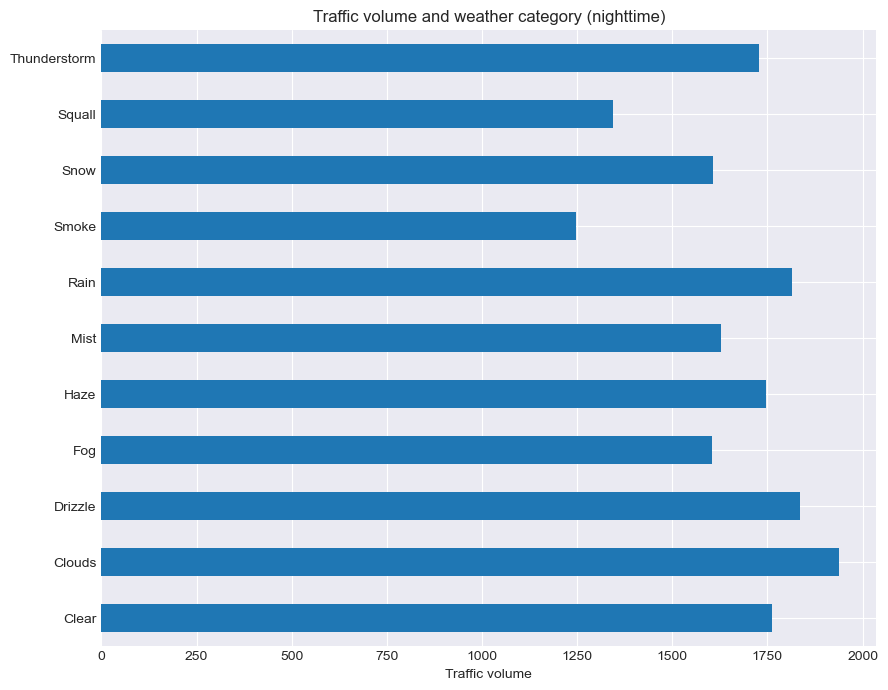

In [30]:
#creating bar plot for `weather_main`
plt.figure(figsize=(10,8))
group_weather_main_night['traffic_volume'].plot(kind='barh')
plt.title('Traffic volume and weather category (nighttime)')
plt.xlabel('Traffic volume')
plt.ylabel('')

plt.show()

Similar to the daytime data. No strong indicators of heavy traffic.

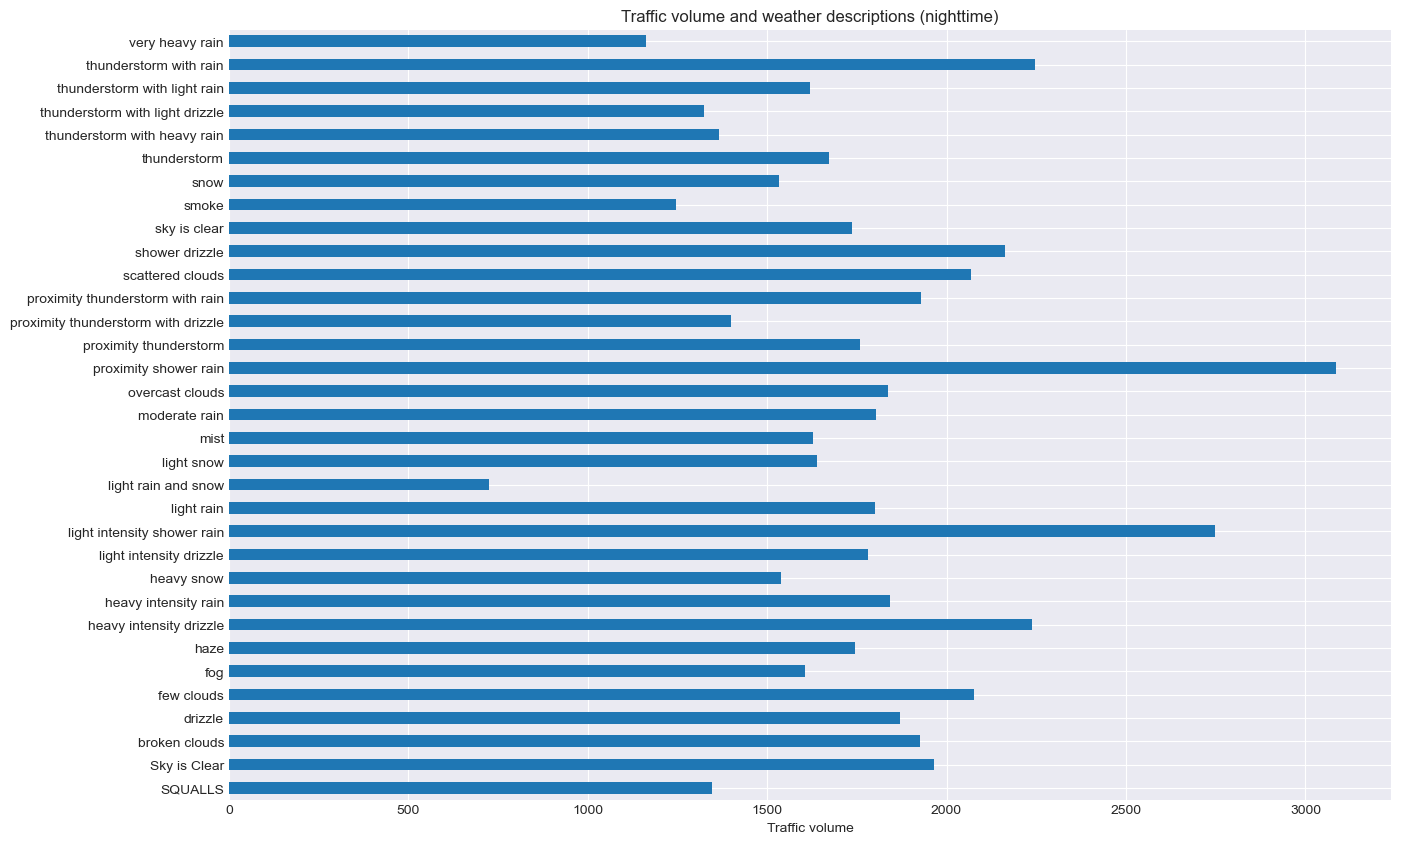

In [31]:
#creating bar plot for `weather_description`
plt.figure(figsize=(15,10))
group_weather_desc_night['traffic_volume'].plot(kind='barh')
plt.title('Traffic volume and weather descriptions (nighttime)')
plt.xlabel('Traffic volume')
plt.ylabel('')

plt.show()

There are some strong indicators here. Light rain and snow is correlated with a dramatic drop in traffic volume.  
Proximity shower rain and light intensity shower rain is correlated with the highest traffic volume. It's not clear why this is.

# 3.0 Conclusion

We have managed to find some indicators of heavy traffic:

- Daytime
  - Traffic volume is greater in the months March-October compared to November-February
  - Traffic is heavier on work days than on the weekends
  - Traffic is heavier during the 07:00 and 16:00 rush hours
  - 'Shower snow' and 'light rain and snow' are correlated with higher traffic volume  

- Nighttime
  - Traffic volume is greater in the months March-October compared to November-February
  - Traffic is heavier on work days than on the weekends
  - Traffic is heavier from 00:00 - 07:00 on weekends compared to week days
  - 'Proximity shower rain' and 'light intensity shower rain' are correlated with greater traffic volume during nighttime